# Mount the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim 
import nltk
from time import time
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity

# Run it to obtain reproducible results across machines (from keras.io)
from __future__ import print_function
import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Dropout, Embedding,Conv1D,GlobalMaxPooling1D,Concatenate,GaussianNoise,LSTM,BatchNormalization
from tensorflow.keras import regularizers

# Import Supporting Files

In [3]:
#Google Word2Vec Pretrained Model
link ='https://drive.google.com/open?id=16A169DxZ-h9qU0i6rXCoSh_djkBWnd9V'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin')   
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

# #GloVe Pretrained Model
# link ='https://drive.google.com/open?id=1p1IN9O_fpSQzPTFB5Y8CCOMXPIPU1WGV'
# fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('glove.twitter.27B.200d.txt')   
# def loadGloveModel(gloveFilePath):
#     print("Loading Glove Model")
#     f = open(gloveFilePath,'r',encoding='utf-8')
#     model = {}
#     for line in f:
#         splitLine = line.split()
#         word = splitLine[0]
#         embedding = np.array([float(val) for val in splitLine[1:]])
#         model[word] = embedding
#     print("Done.",len(model)," words loaded!")
#     return model
# model_GloVe=loadGloveModel('glove.twitter.27B.200d.txt')

16A169DxZ-h9qU0i6rXCoSh_djkBWnd9V


# Import Data

In [7]:
link ='https://drive.google.com/open?id=19nc79hUNZP0xH2IssgSQQTWxNjqAQZnT'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_train_final.csv')  
df_train = pd.read_csv('df_train_final.csv')
df_train=df_train.drop(['Unnamed: 0','index'],1)

link ='https://drive.google.com/open?id=1cDKGfay0oLkGQM0jz4nyk6c9CoE2YIpi'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_test_final.csv')  
df_test = pd.read_csv('df_test_final.csv')
df_test=df_test.drop(['Unnamed: 0','index'],1)

19nc79hUNZP0xH2IssgSQQTWxNjqAQZnT
1cDKGfay0oLkGQM0jz4nyk6c9CoE2YIpi


# Function Definition

In [0]:
def grid_model_W2V(df,input_noise,hidden_dropout,l2_regularizer,activation_conv_list,activation_list,hidden_nodes_1,hidden_nodes_2,optimizer,epochs,batch_size=32):
  '''
  Function for hyperparameter tuning W2V embedding
  '''
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=500)
  X=df['clean_text']
  stratify=df['source']
  y=df['sentiment score']
  max_sequence_length = 50
  for act_conv in activation_conv_list:
    for act in activation_list:
      cvscores = []
      start=time()
      for train,val in kfold.split(X,stratify):
        X_train=X[train].tolist()
        y_train=np.array(y[train])
        X_val=X[val].tolist()
        y_val=np.array(y[val])

        # prepare tokenizer
        t = Tokenizer()
        t.fit_on_texts(X_train)
        X_train = t.texts_to_sequences(X_train)
        X_val = t.texts_to_sequences(X_val)

        # Adding 1 because of reserved 0 index
        vocab_size = len(t.word_index) + 1

        X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
        X_val = pad_sequences(X_val, padding='post', maxlen=max_sequence_length)

        embedding_size=300
        # create a weight matrix for words in training docs
        W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
        for word, i in t.word_index.items():
          if word in model_w2v:
            W2V_embedding_vector = model_w2v[word]
            W2V_embedding_matrix[i] = W2V_embedding_vector
      
        #Define Multiple Filter Sizes
        submodels = []
        embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
        sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
        for kw in (1,2,3,4):    # kernel sizes
            embedded_sequences = embedding_layer(sequence_input)
            sub=GaussianNoise(input_noise)(embedded_sequences)
            sub_submodels=[]
            for i in range(25):
              subsub=BatchNormalization()(sub)
              subsub=Conv1D(1,kw,padding='valid',activation=act_conv,strides=1)(sub)
              subsub=GlobalMaxPooling1D()(subsub)
              subsubmodel=Model(sequence_input,subsub)
              sub_submodels.append(subsubmodel)
            sub_submodel_outputs=[subsubmodel.output for subsubmodel in sub_submodels]
            sub_out=Concatenate(axis=1)(sub_submodel_outputs)
            submodel=Model(sequence_input,sub_out)
            submodels.append(submodel)

        #Concatenate Multiple Filter Sizes
        submodel_outputs = [submodel.output for submodel in submodels]
        out = Concatenate(axis=1)(submodel_outputs)
        out = Dropout(hidden_dropout)(out)
        out = Dense(hidden_nodes_1,activation=act,use_bias=True,bias_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
        out = Dense(hidden_nodes_2,activation='tanh',use_bias=True,bias_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
        out = Dense(1)(out)
        big_model = Model(sequence_input,out)
        big_model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
        history=big_model.fit(X_train,y_train, 
                              batch_size=batch_size,epochs=epochs, 
                              validation_data=(X_val, y_val),verbose=False)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        loss, cos = big_model.evaluate(X_val, y_val, verbose=False)
        print('Cosine Similarity: {}\n'.format(cos))
        cvscores.append(cos)
      end=time()
      print('Time Elapsed: {}'.format(end-start))
      print('Epochs: {}'.format(epochs))
      print('Optimizer: {}'.format(optimizer))
      print('Convolutional Activation Function: {}'.format(act_conv))
      print('Dense Activation Function: {}'.format(act))
      print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
      print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
      print('Input Noise Std: {}'.format(input_noise))
      print('Hidden Dropout Rate: {}'.format(hidden_dropout))
      print('Stratified k-Fold Cosine Similarity Avg Score: {}, Std Score: {}'.format(np.mean(cvscores),np.std(cvscores)))
def model_W2V(df,input_noise,hidden_dropout,l2_regularizer,act_conv,act,hidden_nodes_1,hidden_nodes_2,optimizer,epochs):
  '''
  Function for prediction
  '''
  X_train=df['clean_text'].tolist()
  y_train=np.array(df['sentiment score'])
  max_sequence_length = 50
  start=time()

  # prepare tokenizer
  t = Tokenizer()
  t.fit_on_texts(X_train)
  X_train = t.texts_to_sequences(X_train)

  # Adding 1 because of reserved 0 index
  vocab_size = len(t.word_index) + 1

  X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)

  embedding_size=300
  # create a weight matrix for words in training docs
  W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
  for word, i in t.word_index.items():
    if word in model_w2v:
      W2V_embedding_vector = model_w2v[word]
      W2V_embedding_matrix[i] = W2V_embedding_vector
      
  #Define Multiple Filter Sizes
  submodels = []
  embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
  sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
  for kw in (1,2,3,4):    # kernel sizes
      embedded_sequences = embedding_layer(sequence_input)
      sub=GaussianNoise(input_noise)(embedded_sequences)
      sub_submodels=[]
      for i in range(25):
        subsub=BatchNormalization()(sub)
        subsub=Conv1D(1,kw,padding='valid',activation=act_conv,strides=1)(sub)
        subsub=GlobalMaxPooling1D()(subsub)
        subsubmodel=Model(sequence_input,subsub)
        sub_submodels.append(subsubmodel)
      sub_submodel_outputs=[subsubmodel.output for subsubmodel in sub_submodels]
      sub_out=Concatenate(axis=1)(sub_submodel_outputs)
      submodel=Model(sequence_input,sub_out)
      submodels.append(submodel)

  #Concatenate Multiple Filter Sizes
  submodel_outputs = [submodel.output for submodel in submodels]
  out = Concatenate(axis=1)(submodel_outputs)
  out = Dropout(hidden_dropout)(out)
  out = Dense(hidden_nodes_1,activation=act,use_bias=True,bias_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
  out = Dense(hidden_nodes_2,activation='tanh',use_bias=True,bias_initializer='glorot_uniform',
              kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
  out = Dense(1)(out)
  big_model = Model(sequence_input,out)
  big_model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
  # print(big_model.summary())
  big_model.fit(X_train,y_train, batch_size=32,epochs=epochs,verbose=True)
  return big_model

def grid_model_W2V_lstm(df,input_noise,hidden_dropout,l2_regularizer,activation_list,hidden_nodes_1,hidden_nodes_2,lstm_nodes_1,lstm_nodes_2,optimizer,epochs,batch_size=32):
  '''
  Function for hyperparameter tuning W2V embedding
  '''
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=500)
  X=df['clean_text']
  stratify=df['source']
  y=df['sentiment score']
  max_sequence_length = 50
  for act in activation_list:
    cvscores = []
    start=time()
    for train,val in kfold.split(X,stratify):
      X_train=X[train].tolist()
      y_train=np.array(y[train])
      X_val=X[val].tolist()
      y_val=np.array(y[val])

      # prepare tokenizer
      t = Tokenizer()
      t.fit_on_texts(X_train)
      X_train = t.texts_to_sequences(X_train)
      X_val = t.texts_to_sequences(X_val)

      # Adding 1 because of reserved 0 index
      vocab_size = len(t.word_index) + 1

      X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
      X_val = pad_sequences(X_val, padding='post', maxlen=max_sequence_length)

      embedding_size=300
      # create a weight matrix for words in training docs
      W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
      for word, i in t.word_index.items():
        if word in model_w2v:
          W2V_embedding_vector = model_w2v[word]
          W2V_embedding_matrix[i] = W2V_embedding_vector
      
      #Define LSTM
      sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
      embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
      embedded_sequences = embedding_layer(sequence_input)
      out=GaussianNoise(input_noise)(embedded_sequences)
      # out=LSTM(100,return_sequences=True,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
      # out=LSTM(70,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
      out=tf.keras.layers.CuDNNLSTM(lstm_nodes_1,return_sequences=True)(out)
      out=tf.keras.layers.CuDNNLSTM(lstm_nodes_2)(out)
      out = Dropout(hidden_dropout)(out)
      out = Dense(hidden_nodes_1,activation=act,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
      out = Dense(hidden_nodes_2,activation='tanh',kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
      out = Dense(1)(out)
      model = Model(sequence_input,out)
      model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
      # print(model.summary())
      history=model.fit(X_train,y_train, batch_size=batch_size,epochs=epochs, validation_data=(X_val, y_val),verbose=False)
      plt.figure(figsize=(6,6))
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.ylim((0,0.25))
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()
      loss, cos = model.evaluate(X_val, y_val, verbose=False)
      print('Cosine Similarity: {}\n'.format(cos))
      cvscores.append(cos)
    end=time()
    print('Time Elapsed: {}'.format(end-start))
    print('Epochs: {}'.format(epochs))
    print('Optimizer: {}'.format(optimizer))
    print('Dense Activation Function: {}'.format(act))
    print('LSTM Nodes 1: {}'.format(lstm_nodes_1))
    print('LSTM Nodes 2: {}'.format(lstm_nodes_2))
    print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
    print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
    print('Input Noise Std: {}'.format(input_noise))
    print('Hidden Dropout Rate: {}'.format(hidden_dropout))
    print('Stratified k-Fold Cosine Similarity Avg Score: {}, Std Score: {}'.format(np.mean(cvscores),np.std(cvscores)))

def model_W2V_lstm(df,input_noise,hidden_dropout,l2_regularizer,act,hidden_nodes_1,hidden_nodes_2,lstm_nodes_1,lstm_nodes_2,optimizer,epochs,batch_size=32):
  '''
  Function for prediction
  '''
  X_train=df['clean_text'].tolist()
  y_train=np.array(df['sentiment score'])
  max_sequence_length = 50
  start=time()

  # prepare tokenizer
  t = Tokenizer()
  t.fit_on_texts(X_train)
  X_train = t.texts_to_sequences(X_train)

  # Adding 1 because of reserved 0 index
  vocab_size = len(t.word_index) + 1

  X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)

  embedding_size=300
  # create a weight matrix for words in training docs
  W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
  for word, i in t.word_index.items():
    if word in model_w2v:
      W2V_embedding_vector = model_w2v[word]
      W2V_embedding_matrix[i] = W2V_embedding_vector
      
  #Define LSTM
  sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
  embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
  embedded_sequences = embedding_layer(sequence_input)
  out=GaussianNoise(input_noise)(embedded_sequences)
  # out=LSTM(100,return_sequences=True,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
  # out=LSTM(70,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
  out=tf.keras.layers.CuDNNLSTM(lstm_nodes_1,return_sequences=True)(out)
  out=tf.keras.layers.CuDNNLSTM(lstm_nodes_2)(out)
  out = Dropout(hidden_dropout)(out)
  out = Dense(hidden_nodes_1,activation=act,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
  out = Dense(hidden_nodes_2,activation='tanh',kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer))(out)
  out = Dense(1)(out)
  model = Model(sequence_input,out)
  model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
  # print(model.summary())
  model.fit(X_train,y_train, batch_size=batch_size,epochs=epochs,verbose=True)

  return model

# CNN

In [5]:
t = Tokenizer()
text_lst=['Mathematics is Fun','Especially Linear Algebra']
print('Corpus: {}'.format(text_lst))
t.fit_on_texts(text_lst)
print('Word index: {}'.format(t.word_index))
new_text=['Linear algebra is Mathematics']
print('Input New text: {}'.format(new_text[0]))
a=t.texts_to_sequences(new_text)
print('New text index sequences: {}'.format(a))
print('Padding with maximum length equal 10: {}'.format(pad_sequences(a, padding='post', maxlen=10)))

Corpus: ['Mathematics is Fun', 'Especially Linear Algebra']
Word index: {'mathematics': 1, 'is': 2, 'fun': 3, 'especially': 4, 'linear': 5, 'algebra': 6}
Input New text: Linear algebra is Mathematics
New text index sequences: [[5, 6, 2, 1]]
Padding with maximum length equal 10: [[5 6 2 1 0 0 0 0 0 0]]


## Hyperparameter Tuning

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


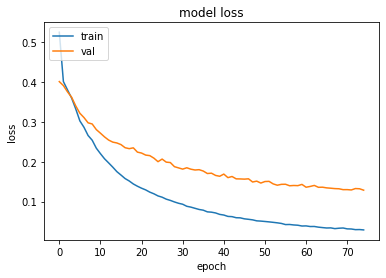

Cosine Similarity: 0.5555555820465088



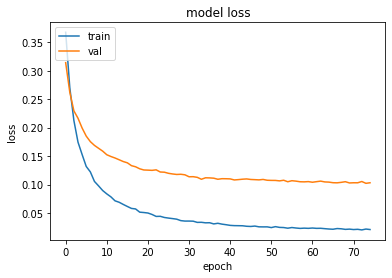

Cosine Similarity: 0.4871794879436493



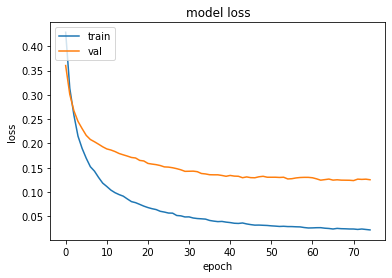

Cosine Similarity: 0.5128205418586731



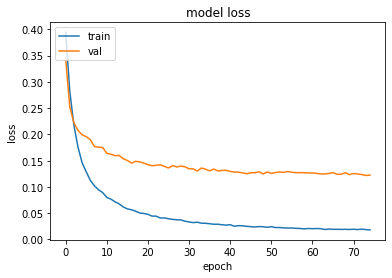

Cosine Similarity: 0.5



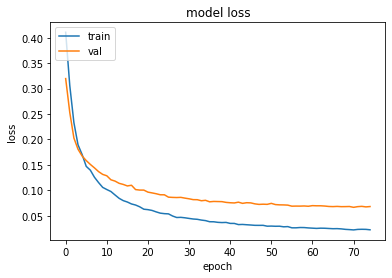

Cosine Similarity: 0.681034505367279



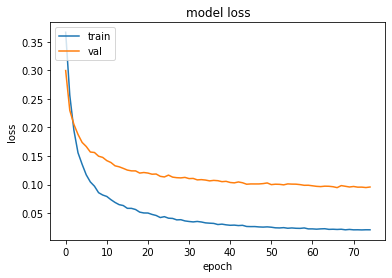

Cosine Similarity: 0.517241358757019



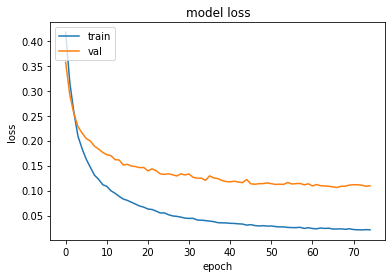

Cosine Similarity: 0.5431034564971924



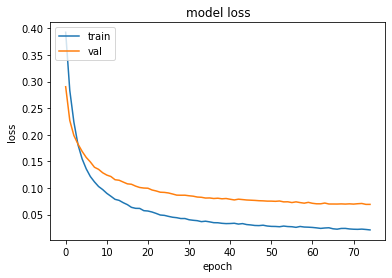

Cosine Similarity: 0.681034505367279



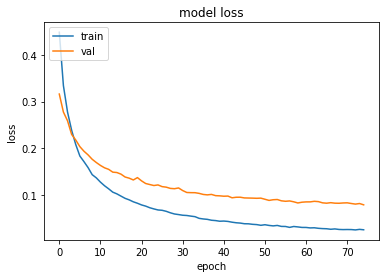

Cosine Similarity: 0.5862069129943848



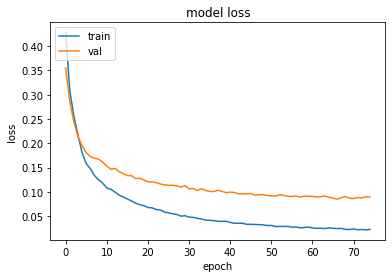

Cosine Similarity: 0.5517241358757019

Time Elapsed: 1784.945651769638
Epochs: 75
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7feebf07bc18>
Convolutional Activation Function: tanh
Dense Activation Function: tanh
Hidden Nodes 1: 15
Hidden Nodes 2: 10
Input Noise Std: 0.01
Hidden Dropout Rate: 0.45
Stratified k-Fold Cosine Similarity Avg Score: 0.5615900158882141, Std Score: 0.0657958909869194


In [8]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0005)

grid_model_W2V(df_train,hidden_nodes_1=15,hidden_nodes_2=10,
               input_noise=0.01,hidden_dropout=0.45,l2_regularizer=0.005,
               activation_conv_list=['tanh'],activation_list=['tanh'],
               epochs=75,optimizer=adam)

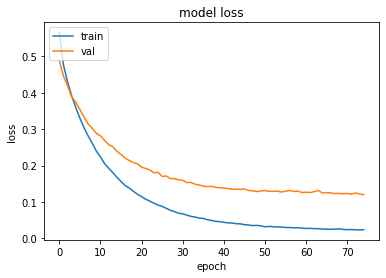

Cosine Similarity: 0.5726495981216431



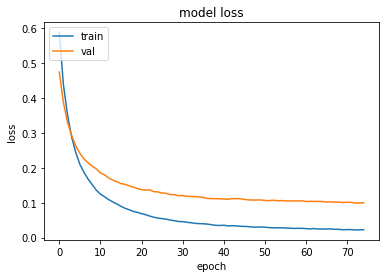

Cosine Similarity: 0.4871794879436493



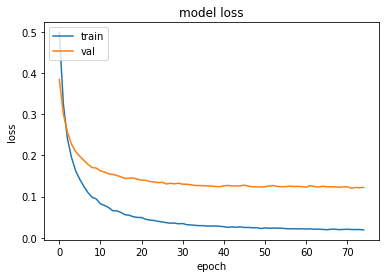

Cosine Similarity: 0.5470085740089417



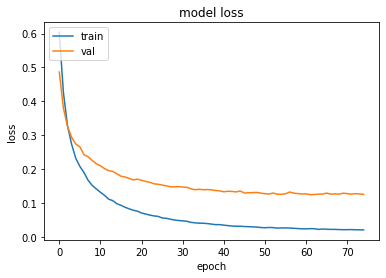

Cosine Similarity: 0.517241358757019



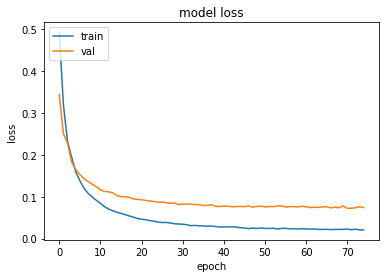

Cosine Similarity: 0.681034505367279



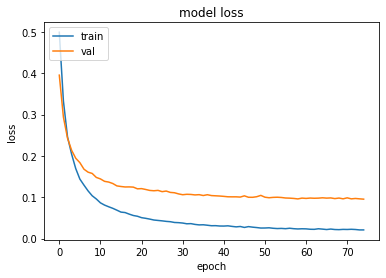

Cosine Similarity: 0.5344827771186829



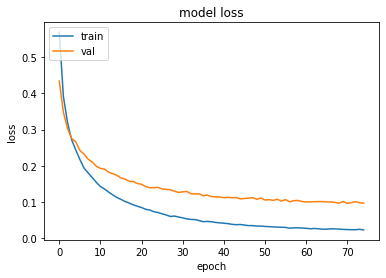

Cosine Similarity: 0.5775862336158752



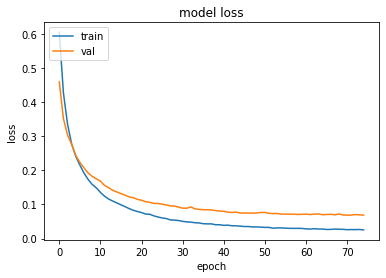

Cosine Similarity: 0.6982758641242981



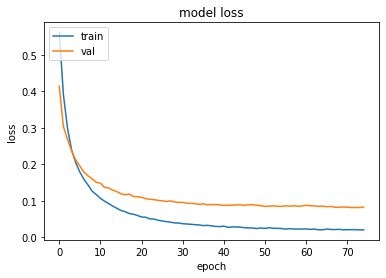

Cosine Similarity: 0.568965494632721



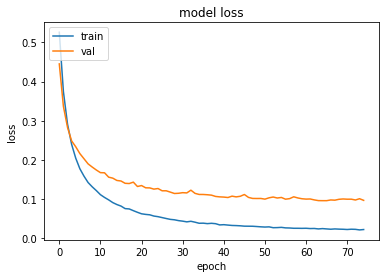

Cosine Similarity: 0.5517241358757019

Time Elapsed: 3304.099804162979
Epochs: 75
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fee4cc439b0>
Convolutional Activation Function: tanh
Dense Activation Function: tanh
Hidden Nodes 1: 15
Hidden Nodes 2: 15
Input Noise Std: 0.01
Hidden Dropout Rate: 0.45
Stratified k-Fold Cosine Similarity Avg Score: 0.573614776134491, Std Score: 0.06362792104482651


In [11]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0005)

grid_model_W2V(df_train,hidden_nodes_1=15,hidden_nodes_2=15,
               input_noise=0.01,hidden_dropout=0.45,l2_regularizer=0.008,
               activation_conv_list=['tanh'],activation_list=['tanh'],
               epochs=75,optimizer=adam)

## Prediction

In [17]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0005)

final_model=model_W2V(df_train,hidden_nodes_1=15,hidden_nodes_2=15,
               input_noise=0.01,hidden_dropout=0.45,l2_regularizer=0.008,
               act_conv='tanh',act='tanh',
               epochs=75,optimizer=adam)

final_model.save("gdrive/My Drive/TA/Seminar 1/Jupyter Notebook/model_CNN_W2V.h5")

Train on 1163 samples
Epoch 1/75
1163/1163 [==============================] - 15s 13ms/sample - loss: 0.6273 - cosine_proximity: 0.1247
Epoch 2/75
1163/1163 [==============================] - 3s 3ms/sample - loss: 0.5195 - cosine_proximity: 0.2812
Epoch 3/75
1163/1163 [==============================] - 3s 3ms/sample - loss: 0.4688 - cosine_proximity: 0.3500
Epoch 4/75
1163/1163 [==============================] - 3s 3ms/sample - loss: 0.4267 - cosine_proximity: 0.4359
Epoch 5/75
1163/1163 [==============================] - 3s 2ms/sample - loss: 0.3947 - cosine_proximity: 0.4824
Epoch 6/75
1163/1163 [==============================] - 3s 3ms/sample - loss: 0.3592 - cosine_proximity: 0.5391
Epoch 7/75
1163/1163 [==============================] - 3s 3ms/sample - loss: 0.3320 - cosine_proximity: 0.6371
Epoch 8/75
1163/1163 [==============================] - 3s 3ms/sample - loss: 0.3062 - cosine_proximity: 0.6887
Epoch 9/75
1163/1163 [==============================] - 3s 3ms/sample - loss: 0.

# LSTM

## Hyperparameter Tuning

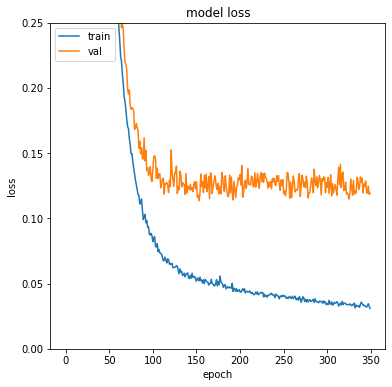

Cosine Similarity: 0.5726495981216431



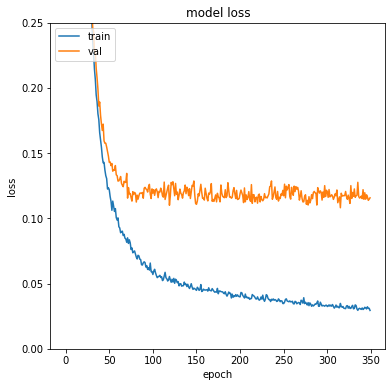

Cosine Similarity: 0.5213675498962402



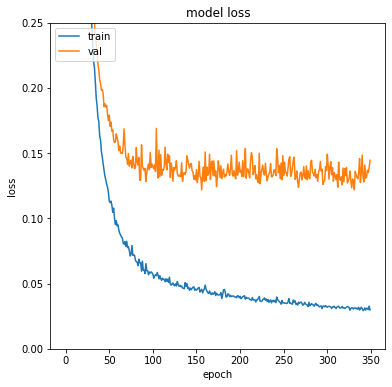

Cosine Similarity: 0.4444444477558136



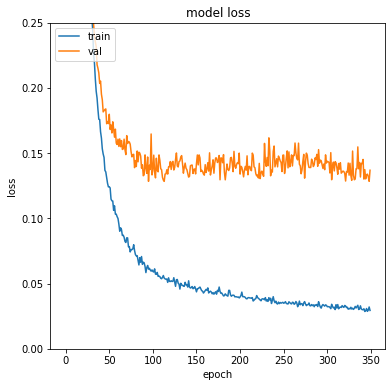

Cosine Similarity: 0.43103447556495667



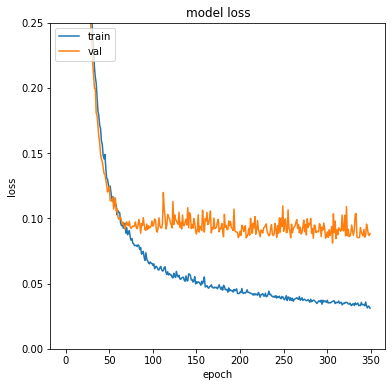

Cosine Similarity: 0.6982758641242981



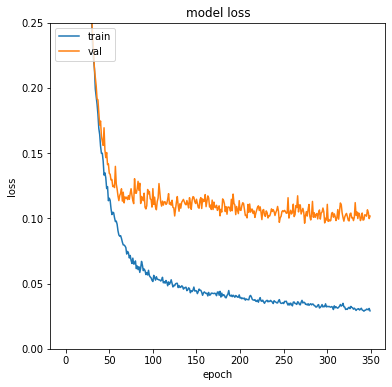

Cosine Similarity: 0.5862069129943848



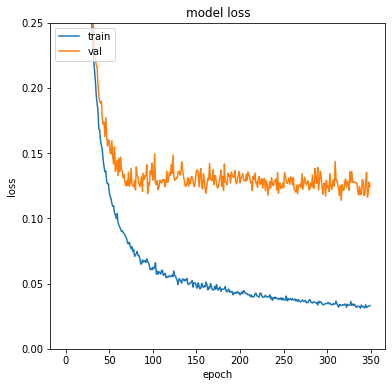

Cosine Similarity: 0.47413793206214905



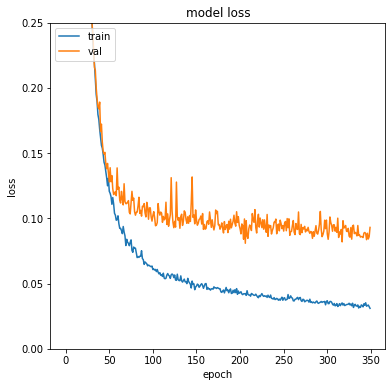

Cosine Similarity: 0.6120689511299133



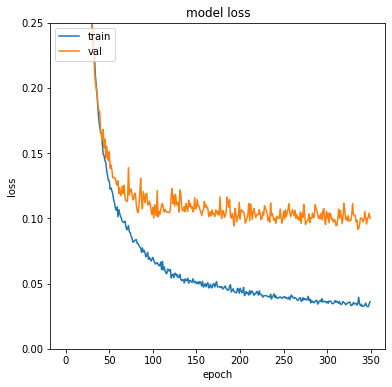

Cosine Similarity: 0.48275861144065857



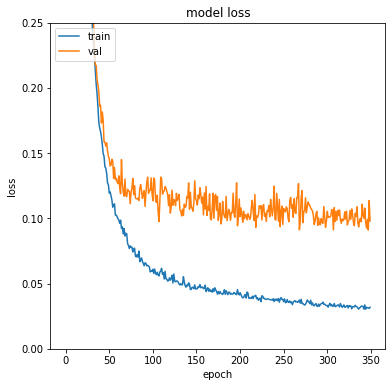

Cosine Similarity: 0.6379310488700867

Time Elapsed: 6937.275693655014
Epochs: 350
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fed83e11b38>
Dense Activation Function: relu
LSTM Nodes 1: 100
LSTM Nodes 2: 100
Hidden Nodes 1: 50
Hidden Nodes 2: 10
Input Noise Std: 0.1
Hidden Dropout Rate: 0.3
Stratified k-Fold Cosine Similarity Avg Score: 0.5460875034332275, Std Score: 0.08463573455810547


In [24]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

grid_model_W2V_lstm(df_train,
                    input_noise=0.1,hidden_dropout=0.3,l2_regularizer=0.05,
                    activation_list=['relu'],lstm_nodes_1=100,lstm_nodes_2=100,
                    hidden_nodes_1=50,hidden_nodes_2=10,
                    optimizer=adam,epochs=350,batch_size=32)

## Prediction

In [29]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

final_model=model_W2V_lstm(df_train,
                    input_noise=0.1,hidden_dropout=0.3,l2_regularizer=0.05,
                    act='relu',lstm_nodes_1=100,lstm_nodes_2=100,
                    hidden_nodes_1=50,hidden_nodes_2=10,
                    optimizer=adam,epochs=350,batch_size=32)

final_model.save("gdrive/My Drive/TA/Seminar 1/Jupyter Notebook/model_LSTM_W2V.h5")

Train on 1163 samples
Epoch 1/350
1163/1163 [==============================] - 18s 16ms/sample - loss: 4.2486 - cosine_proximity: 0.2296
Epoch 2/350
1163/1163 [==============================] - 2s 1ms/sample - loss: 4.0374 - cosine_proximity: 0.2898
Epoch 3/350
1163/1163 [==============================] - 2s 1ms/sample - loss: 3.8425 - cosine_proximity: 0.2898
Epoch 4/350
1163/1163 [==============================] - 2s 1ms/sample - loss: 3.6550 - cosine_proximity: 0.2898
Epoch 5/350
1163/1163 [==============================] - 2s 1ms/sample - loss: 3.4770 - cosine_proximity: 0.2898
Epoch 6/350
1163/1163 [==============================] - 2s 1ms/sample - loss: 3.3085 - cosine_proximity: 0.2898
Epoch 7/350
1163/1163 [==============================] - 2s 1ms/sample - loss: 3.1481 - cosine_proximity: 0.2898
Epoch 8/350
1163/1163 [==============================] - 2s 1ms/sample - loss: 2.9950 - cosine_proximity: 0.2898
Epoch 9/350
1163/1163 [==============================] - 2s 1ms/sample -